In [1]:
import pickle
with open('questions_references.pkl', 'rb') as f:
    questions_references = pickle.load(f)

In [3]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

# Initialize lists to store questions and references
questions = []
references = []
question_to_ref_indices = {}

# Populate the lists
for i, (question, ref_list) in enumerate(questions_references):
    questions.append(question)
    ref_indices = []
    for ref in ref_list:
        references.append(ref[0])
        ref_indices.append(len(questions) + len(references) - 1)  # Index of the reference in the combined list
    question_to_ref_indices[i] = ref_indices  # Store the indices of references for this question

# Combine questions and references into one list
docs = questions + references

# Get embeddings from OpenAI
response = client.embeddings.create(
    input=docs,
    model="text-embedding-3-large"
)

In [4]:
# Initialize an embedding matrix
N = len(docs)
embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

# Populate the embedding matrix
for i, embedding_obj in enumerate(response.data):
    embedding = np.array(embedding_obj.embedding)
    embedding_matrix[i] = embedding

In [5]:
# Calculate cosine similarity between each question and its references and get the mean
cosine_similarities = []
for i, question in enumerate(questions):
    question_embedding = embedding_matrix[i]
    question_similarities = []
    for j in question_to_ref_indices[i]:  # Get the indices of references for this question
        reference_embedding = embedding_matrix[j]
        cosine_similarity = np.dot(question_embedding, reference_embedding) / (np.linalg.norm(question_embedding) * np.linalg.norm(reference_embedding))
        question_similarities.append(cosine_similarity)
    mean_cosine_similarity = np.mean(question_similarities)
    cosine_similarities.append(mean_cosine_similarity)


In [6]:
cosine_similarities = np.array(cosine_similarities)
print(cosine_similarities.mean())
print("Standard Deviation:", np.std(cosine_similarities))
print("Median:", np.median(cosine_similarities))
print("Top 75%:", np.percentile(cosine_similarities, 75))
print("Bottom 25%:", np.percentile(cosine_similarities, 25))


0.26469914333283945
Standard Deviation: 0.1545025208831416
Median: 0.2190299836279486
Top 75%: 0.31690446970640657
Bottom 25%: 0.1602549074203894


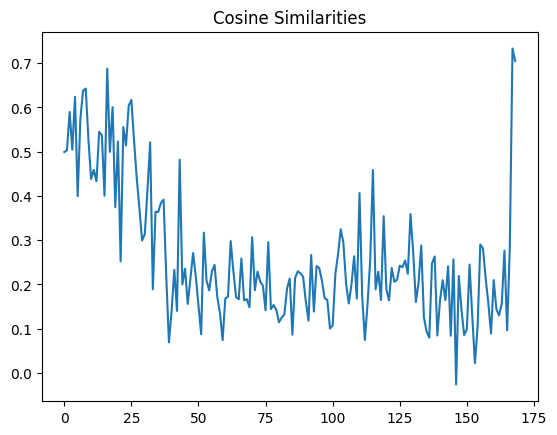

In [7]:
import matplotlib.pyplot as plt

plt.plot(cosine_similarities)
plt.title('Cosine Similarities')
plt.show()

In [4]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

# collection = chroma_client.get_collection("chuck_13", embedding_function=openai_ef)

In [7]:
chroma_client.list_collections()

[Collection(name=questions_BERT), Collection(name=questions_openai_large)]

In [6]:
chroma_client.delete_collection("auto_chunk")

In [9]:
results = collection.query(query_texts=[x[0] for x in questions_references], n_results=5)

In [14]:
import numpy as np

def l2_distance_to_cosine_similarity(l2_distances):
    l2_distances = np.array(l2_distances)
    return (2 - l2_distances) / 2

In [13]:
# results['distances'][0]

l2_distance_to_cosine_similarity(np.array(results['distances'][0]))

array([0.52890321, 0.52054477, 0.4674675 , 0.42482062, 0.41478577])

In [37]:
averages = []
results['embeddings'] 

for x in results['distances']:
    averages.append(l2_distance_to_cosine_similarity(x))

In [40]:
averages = averages.flatten()

0.49960881086440745
Standard Deviation: 0.07415098378472719
Median: 0.4989919223730378
Top 75%: 0.5515348086330434
Bottom 25%: 0.460412755561701


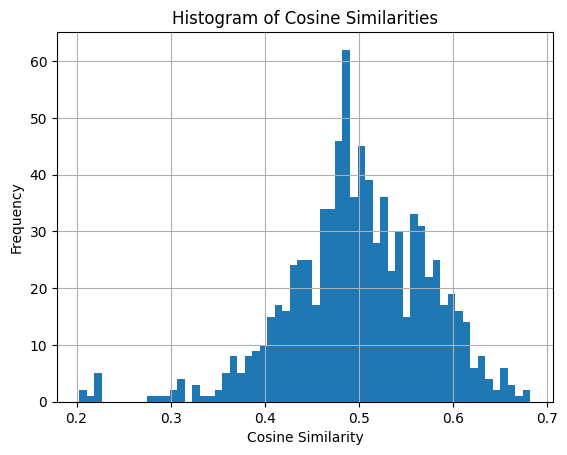

In [43]:
averages = np.array(averages)
print(averages.mean())
print("Standard Deviation:", np.std(averages))
print("Median:", np.median(averages))
print("Top 75%:", np.percentile(averages, 75))
print("Bottom 25%:", np.percentile(averages, 25))

import matplotlib.pyplot as plt

plt.hist(averages, bins=60)
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 0.26469914333283945
# Standard Deviation: 0.1545025208831416
# Median: 0.2190299836279486
# Top 75%: 0.31690446970640657
# Bottom 25%: 0.1602549074203894

# What is the above dist?
T

In [44]:


from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)



def get_sim(target, references):
    response = client.embeddings.create(
        input=[target]+references,
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)

    full_sim = []
    for i in range(1, len(response.data)):
        nparray2 = np.array(response.data[i].embedding)
        cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))
        # cosine_similarities.append(cosine_similarity)
        full_sim.append((target, references[i-1], cosine_similarity))
    # return np.mean(cosine_similarities)
    
    return full_sim



In [30]:
get_sim("What is the capital of France?", ["France?", "Paris is the capital of France.", "The capital of France is Paris.", "Paris is the capital of France.", "The capital of France is Paris."])

0.692377528401863

In [45]:
cosine_similarities = []

# for i, (question, ref_list) in enumerate(questions_references):
#     question_similarities = []
#     for ref in ref_list:
#         question_similarities.append(get_sim(question, ref[0]))
#     mean_cosine_similarity = np.mean(question_similarities)
#     cosine_similarities.append(mean_cosine_similarity)
#     print(f"Question {i + 1}: {question}")
#     print(f"Mean cosine similarity: {mean_cosine_similarity}")
#     print(f"References:")
#     for ref in ref_list:
#         print(f"{ref[0]}")
#     print("\n")

for i, (question, ref_list) in enumerate(questions_references):
    cosine_sim = get_sim(question, [x[0] for x in ref_list])
    cosine_similarities.extend(cosine_sim)
    # print(f"Question {i + 1}: {question}")
    print(f"{i} Mean cosine similarity: {cosine_sim}")

# cosine_similarities = np.array(cosine_similarities)
# print(cosine_similarities.mean())
# print("Standard Deviation:", np.std(cosine_similarities))
# print("Median:", np.median(cosine_similarities))
# print("Top 75%:", np.percentile(cosine_similarities, 75))
# print("Bottom 25%:", np.percentile(cosine_similarities, 25))

0 Mean cosine similarity: [('What gun safety measures is President Biden advocating for?', "I'm proud we beat the NRA when I signed the most significant gun safety law in nearly 30 years because of this Congress.", 0.4250165747093793), ('What gun safety measures is President Biden advocating for?', "I'm demanding a ban on assault weapons and high-capacity magazines. Pass universal background checks.", 0.5289976385381946), ('What gun safety measures is President Biden advocating for?', 'None of this violates the Second Amendment or vilifies responsible gun owners.', 0.3866217107380052)]
1 Mean cosine similarity: [("What actions has the U.S. taken to address the humanitarian crisis in Gaza as mentioned in President Biden's address?", 'The United States has been leading international efforts to get more humanitarian assistance into Gaza.', 0.6421072591929751), ("What actions has the U.S. taken to address the humanitarian crisis in Gaza as mentioned in President Biden's address?", "Tonight

In [47]:
cosine_vals = [x[2] for x in cosine_similarities]
cosine_vals = np.array(cosine_vals)

bottom_10_indexes = np.argsort(cosine_vals)[:10]

for i in bottom_10_indexes:
    print(cosine_similarities[i])

('What measures has President Biden advocated for in addressing gun violence?', 'I say stop it. Stop it, stop it, stop it.', 0.09034310531535676)
('What actions were taken to prevent the Belvidere, Illinois auto plant from shutting down?', 'And together, we succeeded.', 0.13296301910359343)
('What specific directives and actions did President Biden announce regarding international relations and military operations in his State of the Union Address?', 'And they’re announcing they’re going to — they’re going to ca- — have a crossing in Northern Gaza.', 0.1425501999782974)
("What was President Biden's proposed solution to reduce illegal border crossings?", 'But \n— but if it’s only six mon- \n— six weeks, the idea is it’s highly unlikely that people will pay that money and come all that way knowing that they’ll be \n— able to be kicked out quickly.', 0.14800232070240354)
('What specific agendas and bills did President Biden mention in his State of the Union Address?', 'Harness — harness t

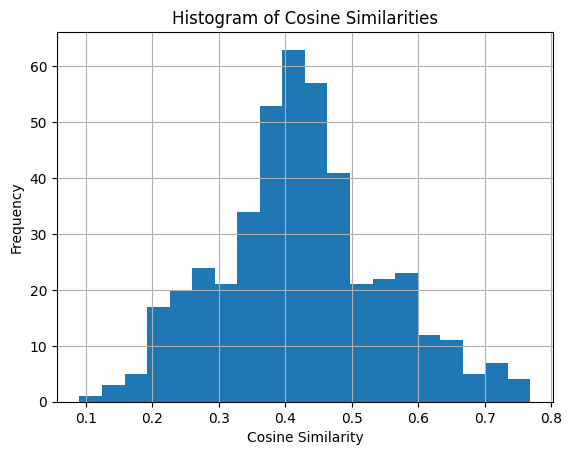

In [46]:
import matplotlib.pyplot as plt

plt.hist([x[2] for x in cosine_similarities], bins=20)
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


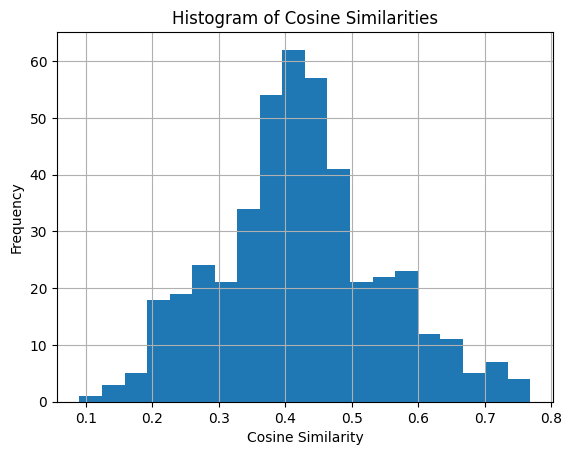

In [36]:
import matplotlib.pyplot as plt

plt.hist(cosine_similarities, bins=20)
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# What is the above dist of?
For each question, get all it's references. Then form a massive list of question and reference pairs. Then get cosine sim of all of them. The above is that dist.

In [58]:


from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

def get_sim(target, references):
    response = client.embeddings.create(
        input=[target]+references,
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)

    # full_sim = []
    for i in range(1, len(response.data)):
        nparray2 = np.array(response.data[i].embedding)
        cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))
        cosine_similarities.append(cosine_similarity)
        # full_sim.append((target, references[i-1], cosine_similarity))
    return np.mean(cosine_similarities)
    
    # return full_sim



In [63]:
for x in questions_references:
    if x[0] == "What significant historical event did President Biden refer to in his State of the Union Address, and how is it related to contemporary political issues he discussed?":
        # print(x[1])
        for y in x[1]:
            print(y[0])
            print(get_sim(x[0], [y[0]]))
        break

A transformational his- — moment in history happened 58 — 59 years ago today in Selma, Alabama. Hundreds of foot soldiers for justice marched across the Edmund Pettus Bridge, named after the Grand Dragon of the Ku Klux Klan, to claim their fundamental right to vote.
0.32880847441459193
But 59 years later, there are forces taking us back in time: voter suppression, election subversion, unlimited dark money, extreme gerrymandering.
0.291727033387274
John Lewis was a great friend to many of us here. But if you truly want to honor him and all the heroes who marched with him, then it’s time to do more than talk.
0.2527202430157975
Pass the Freedom to Vote Act, the John Lewis Voting Right(s) Act.
0.2586297132940427


In [59]:
ref = 
get_sim("What significant historical event did President Biden refer to in his State of the Union Address, and how is it related to contemporary political issues he discussed?", [ref
])

0.38525152128858847

In [50]:
cosine_similarities = []

for i, (question, ref_list) in enumerate(questions_references):
    cosine_sim = get_sim(question, [x[0] for x in ref_list])
    cosine_similarities.append(cosine_sim)
    # print(f"Question {i + 1}: {question}")
    print(f"{i} Mean cosine similarity: {cosine_sim}")

0 Mean cosine similarity: 0.44613944829240076
1 Mean cosine similarity: 0.4707828786478519
2 Mean cosine similarity: 0.37548565440729426
3 Mean cosine similarity: 0.41046716996937926
4 Mean cosine similarity: 0.48400629058612543
5 Mean cosine similarity: 0.32521949966921493
6 Mean cosine similarity: 0.4002422897136795
7 Mean cosine similarity: 0.39072038210792165
8 Mean cosine similarity: 0.3534190123005881
9 Mean cosine similarity: 0.33624791548630606
10 Mean cosine similarity: 0.4400254880617573
11 Mean cosine similarity: 0.4084144710293906
12 Mean cosine similarity: 0.4248472210288242
13 Mean cosine similarity: 0.542155716924018
14 Mean cosine similarity: 0.3396642450773906
15 Mean cosine similarity: 0.40604708520840627
16 Mean cosine similarity: 0.31065813600076053
17 Mean cosine similarity: 0.35236280934911207
18 Mean cosine similarity: 0.26785923872481754
19 Mean cosine similarity: 0.45133854485163505
20 Mean cosine similarity: 0.34451361099024186
21 Mean cosine similarity: 0.425

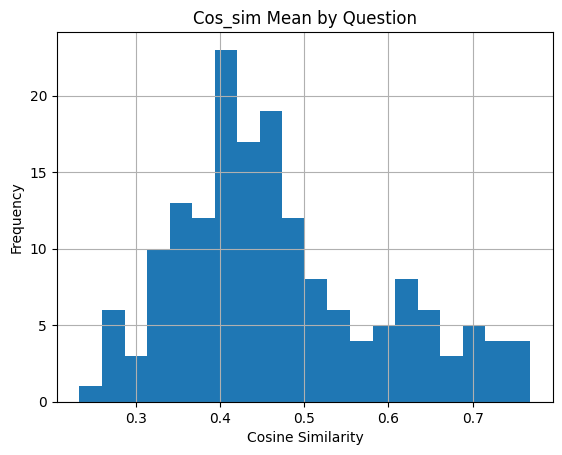

In [51]:
import matplotlib.pyplot as plt

plt.hist(cosine_similarities, bins=20)
plt.title('Cos_sim Mean by Question')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [56]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

def get_sim(target, references):
    reference = "\n".join(references)

    response = client.embeddings.create(
        input=[target, reference],
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)
    nparray2 = np.array(response.data[1].embedding)
    cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))

    if cosine_similarity < 0.45:
        print("\n")
        print(target)
        print(reference)
        print(cosine_similarity)
        print("\n")

    return cosine_similarity

0 Mean cosine similarity: 0.5579750901283687
1 Mean cosine similarity: 0.6510518389529044
2 Mean cosine similarity: 0.5459853990170941
3 Mean cosine similarity: 0.6113152864816104
4 Mean cosine similarity: 0.5713776799037383
5 Mean cosine similarity: 0.5433647638809531
6 Mean cosine similarity: 0.48249371233636695
7 Mean cosine similarity: 0.5416149030608041


What specific legislative actions and initiatives did President Biden urge Congress to pass in his State of the Union Address?
Pass the Freedom to Vote Act, the John Lewis Voting Right(s) Act.
Pass the Equality Act.
Pass the PRO Act for workers’ rights.
Raise the federal minimum wage, because every worker has the right to a decent living more than eig- — seven bucks an hour.
0.4419655261828791


8 Mean cosine similarity: 0.4419655261828791
9 Mean cosine similarity: 0.5311456823159708
10 Mean cosine similarity: 0.6123669137789716
11 Mean cosine similarity: 0.5040371751884208
12 Mean cosine similarity: 0.5800127733886883
14 Mean co

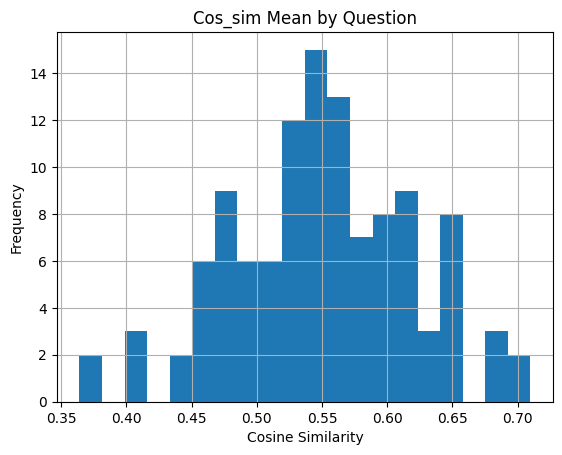

In [57]:
cosine_similarities_2 = []

for i, (question, ref_list) in enumerate(questions_references):
    if len(ref_list) == 1:
        continue
    cosine_sim = get_sim(question, [x[0] for x in ref_list])
    cosine_similarities_2.append(cosine_sim)
    # print(f"Question {i + 1}: {question}")
    print(f"{i} Mean cosine similarity: {cosine_sim}")

cosine_similarities_2 = np.array(cosine_similarities_2)
print("Mean: ", cosine_similarities_2.mean())
print("Standard Deviation:", np.std(cosine_similarities_2))
print("Median:", np.median(cosine_similarities_2))
print("Top 75%:", np.percentile(cosine_similarities_2, 75))
print("Bottom 25%:", np.percentile(cosine_similarities_2, 25))

plt.hist(cosine_similarities_2, bins=20)
plt.title('Cos_sim Mean by Question')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()